# Series temporales ARIMA en la calidad del aire (NO2)
Daniel Núñez

In [1]:
import pickle

import scipy.stats
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib as mpl
from sklearn import svm
from sklearn import ensemble
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

%matplotlib inline

# 1. Series temporales

Utilizaremos los datos de la [calidad del aire](http://mediambient.gencat.cat/es/05_ambits_dactuacio/atmosfera/qualitat_de_laire/principals_contaminants/index.html) del Eixample de Barcelona desde 2011, concretamente del contaminante dióxido de nitrógeno (NO2). Los datos son medidos por la Red de Vigilancia y Previsión de la Contaminación Atmosférica y se pueden obtener para otras estaciones, contaminantes y períodos [aquí](http://mediambient.gencat.cat/es/05_ambits_dactuacio/atmosfera/qualitat_de_laire/vols-saber-que-respires/descarrega-de-dades/index.html).

In [2]:
df = pd.read_csv('NO2_Eixample_2011_2019.csv')
print("Number of rows and columns:", df.shape)
print("Column names:", list(df.columns))
df.head(3)

Number of rows and columns: (3214, 40)
Column names: ['codi_eoi', 'nom_estacio', 'data', 'magnitud', 'contaminant', 'unitats', 'tipus_estacio', 'area_urbana', 'codi_ine', 'municipi', 'codi_comarca', 'nom_comarca', 'h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08', 'h09', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24', 'altitud', 'latitud', 'longitud', 'geocoded_column']


,codi_eoi,nom_estacio,data,magnitud,contaminant,unitats,tipus_estacio,area_urbana,codi_ine,municipi,codi_comarca,nom_comarca,h01,h02,h03,h04,h05,h06,h07,h08,h09,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24,altitud,latitud,longitud,geocoded_column
0,8019043,Barcelona (Eixample),2014-10-03T00:00:00.000,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,60.0,60.0,36.0,39.0,70.0,70.0,67.0,95.0,97.0,106.0,92.0,86.0,102.0,90.0,84.0,93.0,92.0,68.0,70.0,100.0,95.0,97.0,81.0,69.0,26,41.385315,2.1538,POINT (2.1538 41.385315)
1,8019043,Barcelona (Eixample),2014-09-02T00:00:00.000,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,26.0,32.0,45.0,48.0,40.0,50.0,47.0,67.0,68.0,67.0,62.0,61.0,62.0,65.0,46.0,49.0,60.0,59.0,70.0,80.0,74.0,61.0,37.0,20.0,26,41.385315,2.1538,POINT (2.1538 41.385315)
2,8019043,Barcelona (Eixample),2014-05-16T00:00:00.000,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,25.0,17.0,22.0,25.0,39.0,35.0,46.0,90.0,93.0,59.0,54.0,60.0,64.0,60.0,53.0,50.0,67.0,74.0,76.0,77.0,70.0,75.0,69.0,48.0,26,41.385315,2.1538,POINT (2.1538 41.385315)


Convertimos la columna "data" (=fecha) a tipo *datetime* y ordenamos los datos temporalmente:

In [3]:
df["data"] = pd.to_datetime(df["data"])
df.sort_values("data", inplace=True)
df.head(3)

,codi_eoi,nom_estacio,data,magnitud,contaminant,unitats,tipus_estacio,area_urbana,codi_ine,municipi,codi_comarca,nom_comarca,h01,h02,h03,h04,h05,h06,h07,h08,h09,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24,altitud,latitud,longitud,geocoded_column
2912,8019043,Barcelona (Eixample),2011-01-17,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,115.0,101.0,98.0,87.0,81.0,87.0,26,41.385315,2.1538,POINT (2.1538 41.385315)
2704,8019043,Barcelona (Eixample),2011-01-18,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,80.0,81.0,76.0,76.0,71.0,61.0,94.0,115.0,178.0,164.0,158.0,174.0,180.0,133.0,100.0,97.0,99.0,107.0,127.0,141.0,160.0,190.0,194.0,194.0,26,41.385315,2.1538,POINT (2.1538 41.385315)
2805,8019043,Barcelona (Eixample),2011-01-19,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,164.0,152.0,142.0,129.0,121.0,136.0,154.0,189.0,164.0,152.0,NaN,NaN,100.0,92.0,87.0,81.0,91.0,104.0,81.0,78.0,82.0,86.0,88.0,102.0,26,41.385315,2.1538,POINT (2.1538 41.385315)


Vemos que, para cada fila, tenemos las medidas de N02 en µg/m3 para cada hora del día. Para simplificar el análisis, utilizaremos solamente la media diaria, que pasamos a calcular: 

In [4]:
colNs_hourly_measurements = ["h%02d" % h for h in range(1,25)]
print(colNs_hourly_measurements)
df["mean_day"] = df[colNs_hourly_measurements].mean(axis=1)
df[["data", "mean_day"] + colNs_hourly_measurements].head()

['h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08', 'h09', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24']


,data,mean_day,h01,h02,h03,h04,h05,h06,h07,h08,h09,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
2912,2011-01-17,98.428571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,115.0,101.0,98.0,87.0,81.0,87.0
2704,2011-01-18,127.083333,80.0,81.0,76.0,76.0,71.0,61.0,94.0,115.0,178.0,164.0,158.0,174.0,180.0,133.0,100.0,97.0,99.0,107.0,127.0,141.0,160.0,190.0,194.0,194.0
2805,2011-01-19,117.045455,164.0,152.0,142.0,129.0,121.0,136.0,154.0,189.0,164.0,152.0,NaN,NaN,100.0,92.0,87.0,81.0,91.0,104.0,81.0,78.0,82.0,86.0,88.0,102.0
2969,2011-01-20,71.333333,92.0,88.0,84.0,72.0,74.0,59.0,65.0,65.0,78.0,65.0,62.0,68.0,59.0,58.0,59.0,69.0,73.0,80.0,82.0,70.0,70.0,74.0,67.0,79.0
2831,2011-01-21,75.875000,54.0,41.0,40.0,40.0,31.0,29.0,52.0,88.0,105.0,88.0,74.0,71.0,64.0,79.0,82.0,77.0,86.0,106.0,118.0,120.0,111.0,104.0,92.0,69.0


Hay días, como el primero del conjunto de datos, en los que muchas horas no tienen valores válidos. Esto puede resultar en medias diarias muy desviadas. Por tanto, eliminaremos los días con varias medidas inválidas:

In [5]:
print("Number of rows before:", df.shape[0])
df = df[df[colNs_hourly_measurements].isna().sum(axis=1)<5]
print("Number of rows after:", df.shape[0])

Number of rows before: 3214
Number of rows after: 3146


Representamos la serie temporal, compuesta sólo por la medida media que hemos creado, y como índice la columna que nos indica la fecha:

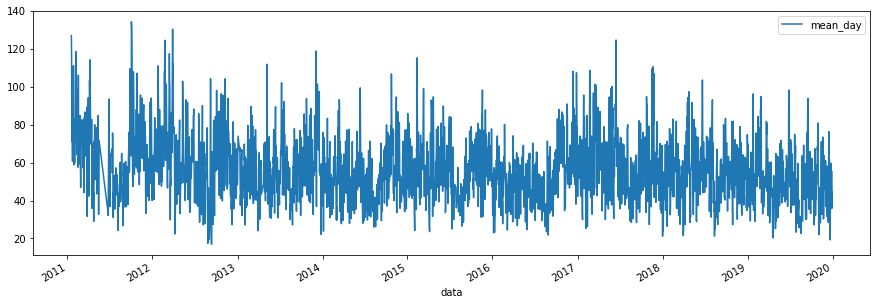

In [6]:
data = df[["data", "mean_day"]].set_index("data")
data.plot(figsize=(15, 5));

Vemos que la variación diaria introduce mucho ruido que no es interesante para analizar la evolución temporal del contaminante en una escala temporal más larga. Por consiguiente, utilizaremos la media de la medida para cada mes en vez de los valores diarios:

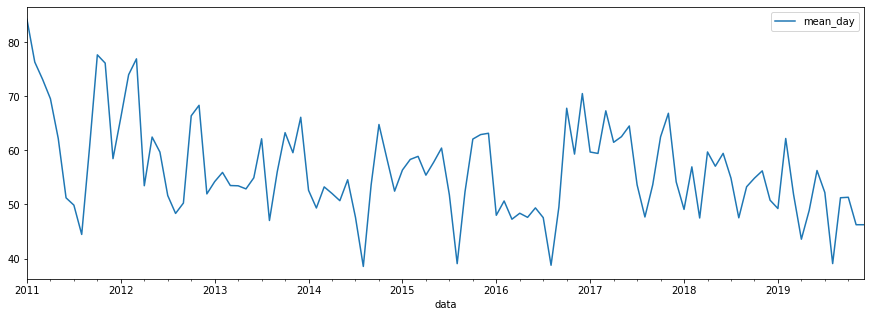

In [7]:
data = df[["data", "mean_day"]].set_index("data").resample("1M").mean()
data.plot(figsize=(15, 5));

Como se puede apreciar, la serie temporal de este contaminante es bastante irregular, pero se intuye cierta heterocedasticidad, tendencia, periodo y ruido, los cuales analizaremos a lo largo de este ejercicio.

Antes de empezar a tratar las diferentes componenetes de una serie temporal, eliminaremos del dataset original un par de años de datos. Así cuando hagamos una predicción a futuro podremos comprobar si se ajusta a los datos reales.

In [8]:
date_min_test = "2018-01-01"
TEST_SIZE = len(data[data.index>=date_min_test])
# train and test are dataframes that contain the values and a datetime index:
train, test = data.iloc[:-TEST_SIZE], data.iloc[-TEST_SIZE:]
# x_train and x_test only contain the values:
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], data.shape[0]))
train.shape, x_train.shape, test.shape, x_test.shape

((84, 1), (84,), (24, 1), (24,))

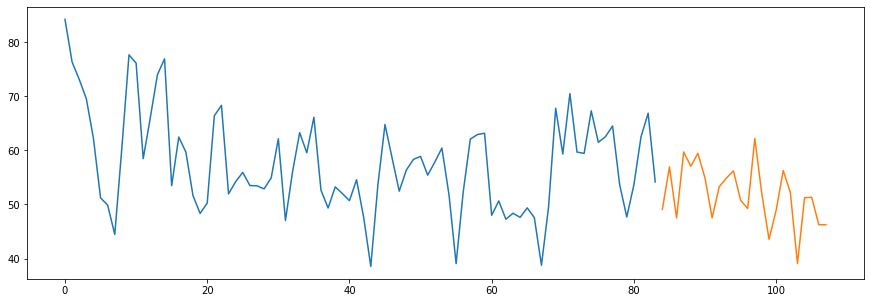

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test);

## 1.1 Componentes de la serie temporal

### 1.1.a. Heterocedasticidad

Se dice que una serie temporal tiene heterocedasticidad cuando la variancia varía con el tiempo. En nuestro caso, observamos que tenemos una cierta heterocedasticidad, ya que la amplitud de onda disminuye ligeramente con el tiempo. Primero vamos a eliminar la heterocedasticidad de la serie temporal. Es decir, que la diferencia entre el mínimo y el máximo de la estacionalidad (anual) sea más o menos la misma a lo largo del tiempo.

Transformamos los datos para eliminar la heterocedasticidad. Para hacerlo trasnformaremos los datos aplicando la función que consideremos que elimina mejor la heterocedasticidad en el dataset, provamos con las tres funciones siguientes: 

- exponencial
- logarítmica
- raiz cuadrada


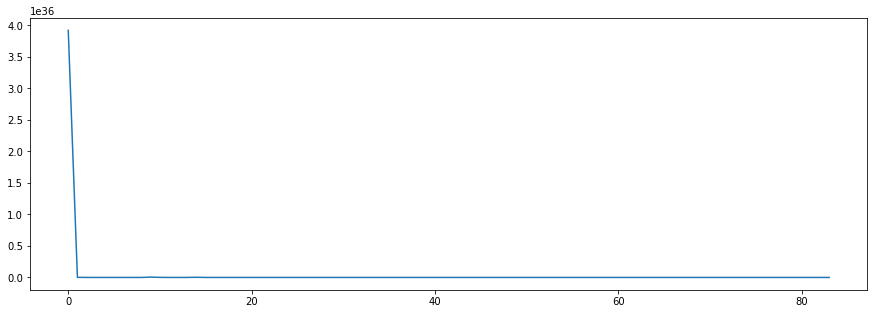

In [10]:
# Aplicamos la funcion exponencial a los datos
train_exp = np.exp(train)

# Graficamos los nuevos datos
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train_exp)
plt.show()

Aplicando la exponencial vemos un pico muy elevado en el primer punto, si eliminamos ese punto nos aparecen picos elevados en otros por lo que no parece ser la mejor funcion para eliminar la heterocedasticidad ya que parecen perder cierta forma datos de forma visual.

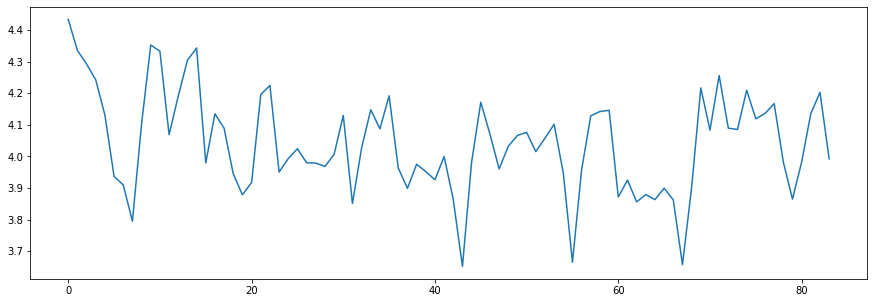

In [11]:
# Aplicamos el logaritmo
train_log = np.log(train)

# Graficmos los nuevos datos
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train_log)
plt.show()

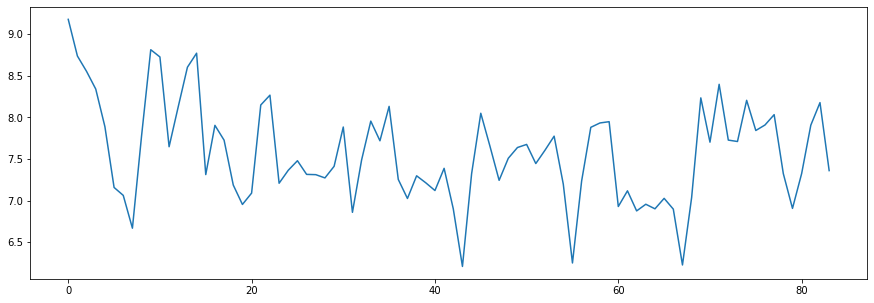

In [12]:
# Aplicamos la raiz cuadrada
train_sqrt = np.sqrt(train)

#Vemos los nuevos datos
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train_sqrt)
plt.show()

Vemos que aplicando tanto el logaritmo como la raiz cuadrada disminuimos la aplitud de los datos en escala diferente, para decidirnos vemos ambos datos en un gráfico.

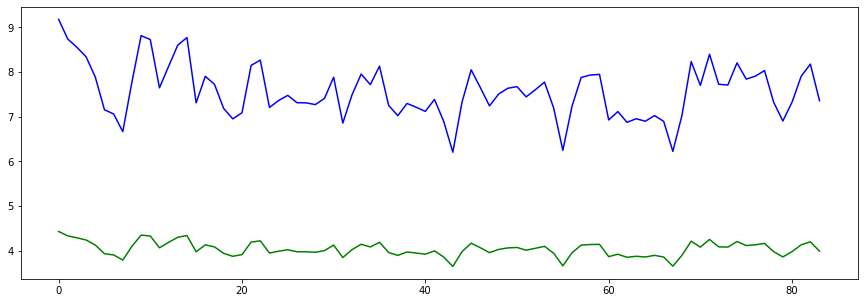

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train_log, c='g')
ax.plot(x_train, train_sqrt, c='b')
plt.show()

Viendo los dos graficos juntos se puede apreciar como es el logaritmo, la funcion que mejor elimina la heterocedasticidad, por lo que nos quedamos con esta.

### 1.1.b. Tendencia

La tendencia es el comportamento que tiene los datos a largo plazo. En nuestra serie temporal tenemos una ligera tendencia lineal decreciente (mejor para nuestra salud). En este apartado eliminaremos la tendencia, quedando una serie temporal con tendencia constante.

Observando la serie podemos apreciar que tenemos una ligera tendencia lineala a la baja:
    - Ajustamos una regresión lineal a los datos (con la heterocedasticidad ya eliminada). Esta será la tendencia que asumimos que tienen los datos.
    - Eliminamos la tendencia de los datos, sustrayendola a los datos que ya tienen la heterocedasticidad eliminada.


In [14]:
# Creamos un modelo de regresión lineal
modelo = LinearRegression(normalize=True, fit_intercept=True)

# Entrenamos el modelo con nuetsros datos que tienen el logaritmo aplicado
modelo.fit(np.arange(train_log.shape[0]).reshape((-1,1)), train_log['mean_day'])

# Hacemos la predicción del modelo entrenado y los guardamos
train_log_reglin = modelo.predict(np.arange(train_log.shape[0]).reshape((-1,1)))


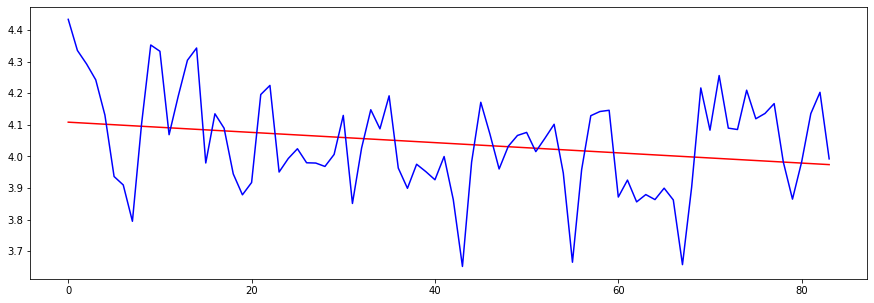

In [15]:
# Hacemos un grafico donde podemos ver la recta de regresion de los datos que es su tendencia
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train_log_reglin, c='r')
ax.plot(x_train, train_log, c='b')
plt.show()


Teniendo ya los datos de la tendencia de nuestros datos (resultado de la regresion) podemos obtener los datos residuales de la regresion. Los residuos son el resultado de quitarle la tendencia a los datos originales.

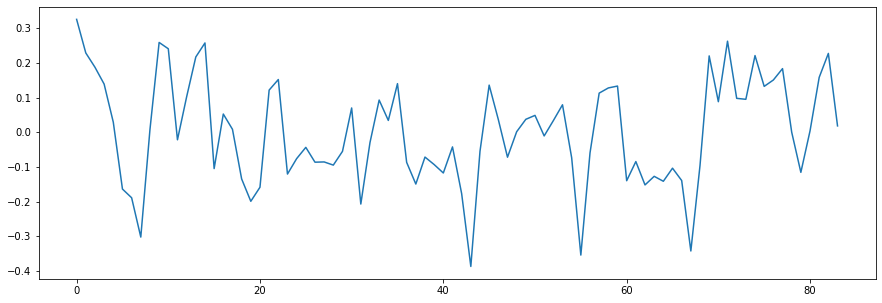

In [16]:
# Calculamos los residuos quitandole la tendencia a los datos
train_log_reglinResiduos = train_log['mean_day'] - train_log_reglin

# Vemos los nuevos datos sin heterocedasticidad ni tendencia
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train_log_reglinResiduos)
plt.show()


### 1.1.c. Estacionalidad

Definimos estacionalidad como la variación cíclica que se produce en los datos. En este apartado se buscaremos la estacionalidad, la cual eliminaremos despues. 

En primer lugar buscaremos el ciclo, es decir, cada cuando se repiten los datos. Para encontrarlo usaremoas la autocorrelación. La idea es que se tiene que comparar:
    
- La serie original con la serie empezando en el segundo punto (es decir, serie[1:])
- La serie original con la serie empezando en el tercer punto (es decir, serie[2:])
- ...
    
En el momento en que vuelva a empezar el ciclo, la serie será muy parecida a la serie original, y, por lo tanto, la correlación será muy elevada. El punto donde la correlación sea máxima, será el ciclo de la serie. 

In [18]:
# Definimos una funcion de autocorrelacion 
# En ella lo que hacemos es seleccionar los datos avanzando por los datos para calcular su correlacion
def autocorr(x, t=1):
    return np.corrcoef(np.array([x[t:], x[:-t]]))

# Creamos un dataframe donde vamos a guardar los datos de la correlacion
df = pd.DataFrame(columns=['i', 'corr'], index=range(23))

# Hacemos un bucle para los 22 primeros valores de de nuestros datos donde aplicamos la funcion creada y guardamos los datos
for i in range(1,23): 
    x = autocorr(train_log_reglinResiduos, t=i)
    df['corr'][i] = x[0,1]
    df['i'][i] = i
    
# Vemos el dataframe
df

,i,corr
0,NaN,NaN
1,1,0.50023
2,2,0.0722989
3,3,-0.00356763
4,4,-0.00427089
5,5,-0.00469039
6,6,-0.095569
7,7,-0.114539
8,8,0.0139911
9,9,-0.109519


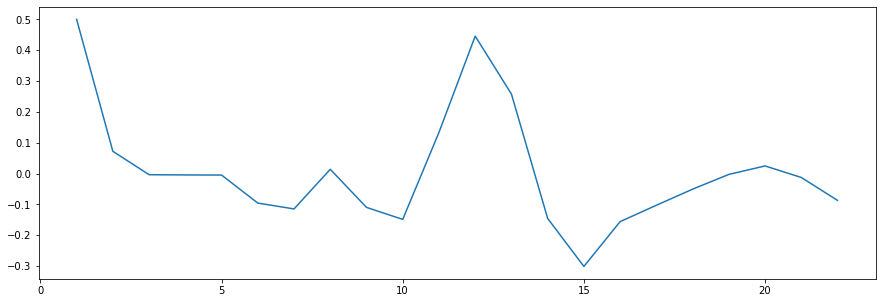

In [19]:
# Hacemos un grafico donde vemos los resultados de las autocorrelaciones
x_corr = df['corr'][1:23]
x_train_corr = x_train[1:23]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train_corr, x_corr)
plt.show()

Si nos fijamos en el grafico, el datos más alto de las autocorrelaciones lo tenemos en t=1, esto querria decir que la estacionalidad es mensual, pero si vemos el grafico con los datos queda claro que la estacionalidad no es mensual ya que sino todos los datos serian iguales, por lo que omitimos este primer valor. El siguiente valor que tenemos mas alto y el único pico que hay en el grafico de autocorrelaciones es en t=12 con mucha diferencia con el resto de datos. Si nos fijamos en los datos de la evolucion del NO2 que tenemos esto tendria mucho mas sentido, por lo que la estacionalidad de nuestros datos se produce cada 12 meses.

In [20]:
df['corr'][12] # valor maximo sin ocntar el primero

0.44582246229631

### 1.1.d. Aplicamos un modelo SARIMA 

Para tratar la estacionalidad aplicaremos un modelo SARIMA. Las siglas corresponden a "stationality ARIMA", es decir, un modelo ARIMA con estacionalidad (la que acabamos de encontrar).

El modelo ARIMA nos va a permitir tratar el ruido que queda al eliminar la heterocedasticidad, tendencia y estacionalidad. Para hacerlo tiene en cuenta las siguientes componentes:

- AR: auto-regressive, se denomina *p*. Tiene en cuenta la correlación con sus lags, es decir, mira si las observaciones pasadas afectan para calcular el siguiente punto. 
- I: integrated, se denomina *d*. Es el orden de diferenciación, en nuestro caso no es necesario, puesto que la serie ya no tiene heterocedasticidad ni tendencia.
- MA: moving-average, se denomina *q*. Tiene en cuenta la correlación con los lags de los errores, es decir, una vez se ha aplicado el modelo, mira los errores del modelo versus los datos reales.

Para más información sobre los ARIMA se puede consultar este link: https://otexts.com/fpp2/arima.html

Los modelos SARIMA dependen de varios parámetros (p,d,q)(P,D,Q)s, donde los primeros (minúsculas) corresponden a AR, I, MA de la serie normal, u los segundos (mayúsculas) a AR, I, MA con estacionalidad. 

Para encontrar estos parámetros tenemos que mirar los gráficos PACF (<i>partial autocorrelation function</i>) y ACF (<i>autocorrelation function</i>).

El gráfico PACF nos determina el parámetro *p*, es decir, la AR.

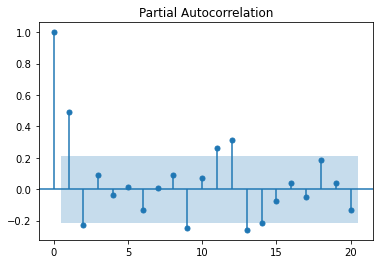

In [14]:
# Supongamos que los datos sin heterocedasticidad ni tendencia se llaman train_log_trend
plot_pacf(train_log_trend)
plt.show()

Para leer este gráfico, simplemente nos tenemos que fijar en los valores que salen fuera del intervalo de confianza (zona azul).

Nada mas empezar hay dos valores fuera del intervalo. De todos modos el primero no se debe tener en cuenta, puesto que mira la correlación de un valor consigo mismo, y esta siempre será 1. Si no tenemos en cuenta este primer valor, en el primer ciclo (primeros 12 puntos) hay tres valores fuera del intervalo de confianza, pero uno de ellos justo en la frontera, con lo cual escogemos **p = 2**. También podríamos probar con p=1 o p=3.

Cuando se repite el ciclo, es decir, a partir del valor 11, hay tres valores claramente fuera del intervalo, con lo cual **P = 3**. También podríamos probar con P=2 o p=4.

Veamos ahora el gráfico ACF, este determinará el valor de *q*.

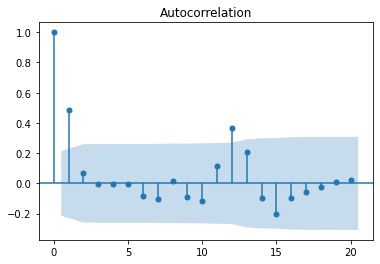

In [15]:
# Supongamos que los datos sin heterocedasticidad ni tendencia se llaman train_log_trend
plot_acf(train_log_trend)
plt.show()

Este gráfico se lee igual que el anterior. 

Ignorando el primer lag, vemos que al empezar hay un valor fuera del intervalo, con lo cual **q = 1**. Cuando se repite el ciclo, es decir, a partir del valor 11, solo hay un valor fuera del intervalo, con lo cual **Q = 1**.

Como los datos no tienen ni tendencia ni heterocedasticidad, **d = D = 0**.

Como hemos visto en el apartado anterior, el ciclo es 12, con lo cual **s = 12**.

Teniendo esto en cuenta, aplicamos un modelo SARIMA a los datos sin heterocedasticidad ni tendencia.

In [21]:
# Creamos el modelo SARIMAX con los parametros mencionados donde:
# (p,d,q)(P,D,Q)s = (2,0,1)(3,0,1)12
modelo_SARIMA = SARIMAX(train_log_reglinResiduos, order=(2,0,1), seasonal_order=(3,0,1,12), simple_differencing=True)

# Entrenamos el modelo
modelo_SARIMA_fit = modelo_SARIMA.fit(disp=False)

# Vemos el resultado del modelo
print(modelo_SARIMA_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           mean_day   No. Observations:                   84
Model:             SARIMAX(2, 0, 1)x(3, 0, 1, 12)   Log Likelihood                  67.059
Date:                            Mon, 28 Dec 2020   AIC                           -118.118
Time:                                    12:43:06   BIC                            -98.671
Sample:                                01-31-2011   HQIC                          -110.300
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0104      0.923      0.011      0.991      -1.799       1.820
ar.L2          0.3558      0.615   

C:\Users\Dany\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


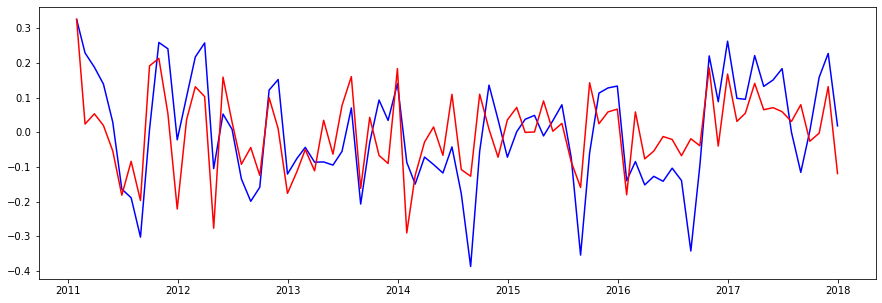

In [22]:
# Obtenemos los residuos del modelo
residuals = pd.DataFrame(modelo_SARIMA_fit.resid)

# Hacemos un grafico con los datos y los predichos por el modelo
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train_log_reglinResiduos, c='b')
ax.plot(residuals[0], c='r')
plt.show()


## 1.2. Predicción

Vamos a predecir los dos proximos años y comparar la predicción con los datos reales. Seguiremos los siguientes pasos:

   - Generar la predicción con el SARIMA
   - Añadir tendencia
   - Añadir heterocedasticidad

### 1.2.a. Predicción SARIMA

Utilizaremos el modelo SARIMA que hemos fitado antes para predecir los dos próximos años.

Generamos las previsiones para dos años de test mediante el modelo SARIMA fitado en el apartado anterior.

In [23]:
# Hacemos una prediccion indicando el numero de puntos a estimar, en nuestro caso la longitud del test
pred_uc = modelo_SARIMA_fit.get_forecast(steps = len(test))

# Calculamos el intervalo de confianza de los datos predichos.
pred_ci = pred_uc.conf_int()

#Guardamos los datos predichos y su intervalo
prediccion_media = pred_uc.predicted_mean
prediccion_media_confInf = pred_ci.iloc[:, 0]
prediccion_media_confSup = pred_ci.iloc[:, 1]

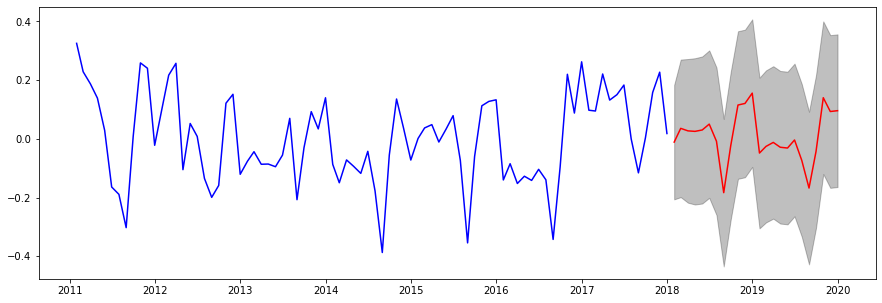

In [24]:
# Hacemos un grafico done vemos la prediccion y su intervalo de confianza
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot( train_log_reglinResiduos, c='b')
ax.plot( prediccion_media, c='r')
ax.fill_between(pred_ci.index,
                prediccion_media_confInf,
                prediccion_media_confSup, color = 'k', alpha = .25)
plt.show()


### 1.2.b. Tendencia

Anteriormente hemos visto que los datos de la serie temporal tienen una tendencia lineal y la hemos calculado mediante una regresión lineal. Vamos a añadir esta tendencia a nuestra predicción.

Añadimos a la serie anterior de previsiones del modelo la tendencia que habíamos eliminado en el apartado 1.1.b.

In [25]:
# Añadimos los residuos de la regresiones lineales y asi le añadimos la tendencia que tenian
# A los datos predichos le añadimos los residuos de los ultimos dos años del train ya que serán los mas cercanos
train_log_reglinResiduos_menosresiduoslm = train_log_reglinResiduos + train_log_reglin 
prediccion_media_menosresiduoslm = prediccion_media + train_log_reglin[60:84]
prediccion_media_confInf_menosresiduoslm = prediccion_media_confInf + train_log_reglin[60:84]
prediccion_media_confSup_menosresiduoslm = prediccion_media_confSup + train_log_reglin[60:84]

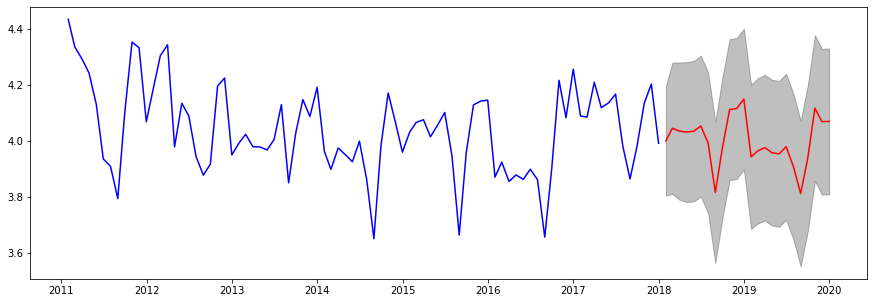

In [26]:
# Hacemos el grafico
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot( train_log_reglinResiduos_menosresiduoslm, c='b')
ax.plot( prediccion_media_menosresiduoslm, c='r')
ax.fill_between(pred_ci.index,
                prediccion_media_confInf_menosresiduoslm,
                prediccion_media_confSup_menosresiduoslm, color = 'k', alpha = .25)
plt.show()

### 1.2.c. Heterocedasticidad

En el primer apartado de esta práctica hemos visto que la serie temporal tiene heterocedasticidad y la hemos eliminado transformando los datos. En este apartado haremos la transfromación inversa para añadir heterocedasticidad a nuestra predicción.

Añadimos a la serie anterior de previsiones del modelo (a la que ya ha recuperado la tendencia), la heterocedasticidad que habíamos eliminado en el apartado 1.1.a, aplicando la función inversa(exponenecial) a la aplicada anteriormente. 

In [27]:
# Aplicamos la funcion exponenecial y asi quitamos el la funcion logaritmica que pusimos para quitar la heterocedasticidad
train_log_reglinResiduos_menosresiduoslm_EXP = np.exp(train_log_reglinResiduos_menosresiduoslm)
prediccion_media_menosresiduoslm_EXP = np.exp(prediccion_media_menosresiduoslm)
prediccion_media_confInf_menosresiduoslm_EXP = np.exp(prediccion_media_confInf_menosresiduoslm)
prediccion_media_confSup_menosresiduoslm_EXP = np.exp(prediccion_media_confSup_menosresiduoslm)

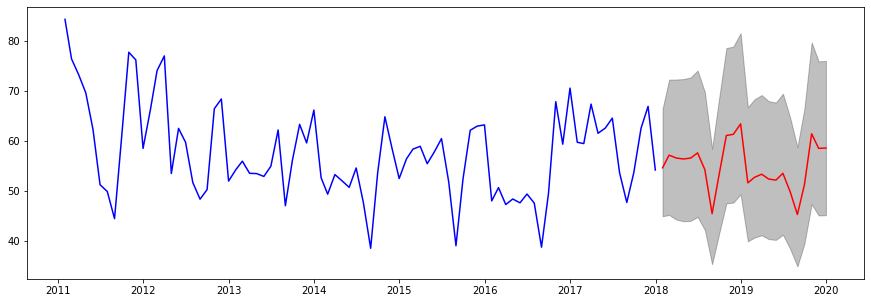

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot( train_log_reglinResiduos_menosresiduoslm_EXP, c='b')
ax.plot( prediccion_media_menosresiduoslm_EXP, c='r')
ax.fill_between(pred_ci.index,
                prediccion_media_confInf_menosresiduoslm_EXP,
                prediccion_media_confSup_menosresiduoslm_EXP, color = 'k', alpha = .25)
plt.show()

### 1.2.d. Precisión del modelo

Añadimos al gráfico anterior la serie real para los dos años de predicción.

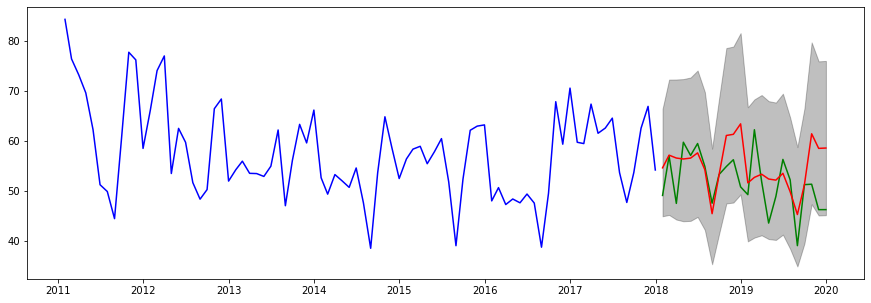

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot( train_log_reglinResiduos_menosresiduoslm_EXP, c='b')
ax.plot( test, c='green')
ax.plot( prediccion_media_menosresiduoslm_EXP, c='r')
ax.fill_between(pred_ci.index,
                prediccion_media_confInf_menosresiduoslm_EXP,
                prediccion_media_confSup_menosresiduoslm_EXP, color = 'k', alpha = .25)
plt.show()

Calculamos la precisión del modelo en el conjunto de test con las métricas R2 y Mean Absolute Error.


In [30]:
print("R2: " + str(r2_score(test, prediccion_media_menosresiduoslm_EXP)))
print("Mean Absolute Error: " + str(mean_absolute_error(test, prediccion_media_menosresiduoslm_EXP)))

R2: -0.42889728363071766
Mean Absolute Error: 4.937969884996055


Anàlisis de los resultados obtenidos por el modelo, tanto visualmente como analizando los valores de las métricas calculadas

Visualmente los reusltados parecen buenos viendo el gráfico ya que, por un lado, los valores que predecimos del NO2 para dos años son muy similares a los que hay en realidad, y por otro, todos los resulados reales de estos dos años estan comprendidos entre nuestro intervalo de confianza, por lo que parece que se obtienen buenos datos del modelo. 
Sin embargo, si nos fijamos en las metricas calculadas, no parecen tan buenos. Concretamente nos da un coeficiente de determinacion (R2) negativo, lo que quiere decir que los resultado son peores que un modelo con datos constantes. No entendemos muy bien por qué da este R2 negativo cuando visualmente parece un buen modelo.